In [12]:
import matplotlib
import pandas as pd
import numpy as np
import csv
import re
%matplotlib inline 
import matplotlib.pyplot as plt

## Predictions of transmembrane helix domain with TMHMM2.0

Fasta file for the full human genome was runned on:
http://www.cbs.dtu.dk/services/TMHMM-2.0/

User guide:
http://www.cbs.dtu.dk/services/TMHMM-2.0/TMHMM2.0.guide.html#output

### Columns descriptions:
- "len=": the length of the protein sequence.
- "ExpAA=": The expected number of amino acids intransmembrane helices (see above).
- "First60=": The expected number of amino acids in transmembrane helices in the first 60 amino acids of the protein (see above).
- "PredHel=": The number of predicted transmembrane helices by N-best.
- "Topology=": The topology predicted by N-best.

The topology is given as the position of the transmembrane helices separated by 'i' if the loop is on the inside or 'o' if it is on the outside. The above example 'i7-29o44-66i87-109o' means that it starts on the inside, has a predicted TMH at position 7 to 29, the outside, then a TMH at position 44-66 etc.

In [2]:
# Loading transmembrane helix domain data
TMD = pd.read_table('data/TMHMM_result.txt', delim_whitespace=True, header=None)
TMD = TMD.rename(columns={0: 'ID', 1:'len', 2: 'ExpAA', 
                       3: 'First60', 4: 'PredHel', 5: 'Topology'})
TMD.head()

,ID,len,ExpAA,First60,PredHel,Topology
0,sp|Q96IY4|CBPB2_HUMAN,len=423,ExpAA=2.22,First60=1.15,PredHel=0,Topology=o
1,sp|P22362|CCL1_HUMAN,len=96,ExpAA=0.07,First60=0.07,PredHel=0,Topology=o
2,sp|Q8NCR9|CLRN3_HUMAN,len=226,ExpAA=90.50,First60=22.95,PredHel=4,Topology=i13-35o94-116i129-151o179-201i
3,sp|Q8IUK8|CBLN2_HUMAN,len=224,ExpAA=9.17,First60=8.91,PredHel=0,Topology=o
4,sp|Q9BX69|CARD6_HUMAN,len=1037,ExpAA=0.00,First60=0.00,PredHel=0,Topology=o


In [3]:
TMD.shape

(20364, 6)

In [4]:
TMD['len'] = TMD['len'].map(lambda x: x.replace('len=', ''))
TMD['ExpAA'] = TMD['ExpAA'].map(lambda x: x.replace('ExpAA=', ''))
TMD['First60'] = TMD['First60'].map(lambda x: x.replace('First60=', ''))
TMD['PredHel'] = TMD['PredHel'].map(lambda x: x.replace('PredHel=', ''))
TMD['Topology'] = TMD['Topology'].map(lambda x: x.replace('Topology=', ''))
TMD['Topology'] = TMD['Topology'].map(lambda x: re.findall('\d{1,}-\d{1,}', x))
TMD['ID'] = TMD['ID'].map(lambda x: x.split('|')[1])
TMD.head()

,ID,len,ExpAA,First60,PredHel,Topology
0,Q96IY4,423,2.22,1.15,0,[]
1,P22362,96,0.07,0.07,0,[]
2,Q8NCR9,226,90.50,22.95,4,"[13-35, 94-116, 129-151, 179-201]"
3,Q8IUK8,224,9.17,8.91,0,[]
4,Q9BX69,1037,0.00,0.00,0,[]


In [5]:
l_topo = TMD['Topology'].values
l_len = TMD['len'].values.astype(int)

In [6]:
l_len[0]

423

In [7]:
l_seq =[]
for i in range(len(l_len)):
    seq = [0]* l_len[i]
    if l_topo[i] != []:
        for x in l_topo[i]:
            interval = re.findall('\d{1,}', x)
            seq[int(interval[0]):int(interval[1])+1] = [1 for n in seq[int(interval[0]):int(interval[1])+1]]
    sequence = ''.join(str(x) for x in seq)
    l_seq.append(sequence)
TMD['Topology Seq'] = l_seq
TMD.head()   

,ID,len,ExpAA,First60,PredHel,Topology,Topology Seq
0,Q96IY4,423,2.22,1.15,0,[],0000000000000000000000000000000000000000000000...
1,P22362,96,0.07,0.07,0,[],0000000000000000000000000000000000000000000000...
2,Q8NCR9,226,90.50,22.95,4,"[13-35, 94-116, 129-151, 179-201]",0000000000000111111111111111111111110000000000...
3,Q8IUK8,224,9.17,8.91,0,[],0000000000000000000000000000000000000000000000...
4,Q9BX69,1037,0.00,0.00,0,[],0000000000000000000000000000000000000000000000...


In [8]:
len(TMD['Topology Seq'][0])

423

## SignalIP5 Prediction

site: https://services.healthtech.dtu.dk/service.php?SignalP-5.0

papers: 
- https://www.nature.com/articles/s41587-019-0036-z
- https://academic.oup.com/peds/article/10/11/1241/1506251


Signal peptide and cleavage sites in gram+, gram- and eukaryotic amino acid sequences
The SignalP 5.0 server predicts the presence of signal peptides and the location of their cleavage sites in proteins from Archaea, Gram-positive Bacteria, Gram-negative Bacteria and Eukarya. In Bacteria and Archaea, SignalP 5.0 can discriminate between three types of signal peptides:

- Sec/SPI: "standard" secretory signal peptides transported by the Sec translocon and cleaved by Signal Peptidase I (Lep)
- Sec/SPII: lipoprotein signal peptides transported by the Sec translocon and cleaved by Signal Peptidase II (Lsp)
- Tat/SPI: Tat signal peptides transported by the Tat translocon and cleaved by Signal Peptidase I (Lep)

In [9]:
SP = pd.read_table('data/signalIP5_preds.txt')
SP.head()

,ID,Prediction,SP(Sec/SPI),OTHER,CS Position
0,sp_Q96IY4_CBPB2_HUMAN,SP(Sec/SPI),0.956504,0.043496,CS pos: 22-23. VFA-FQ. Pr: 0.8438
1,sp_P22362_CCL1_HUMAN,SP(Sec/SPI),0.998593,0.001407,CS pos: 23-24. VDS-KS. Pr: 0.8532
2,sp_Q8NCR9_CLRN3_HUMAN,OTHER,0.161518,0.838482,NaN
3,sp_Q8IUK8_CBLN2_HUMAN,SP(Sec/SPI),0.909754,0.090246,CS pos: 51-52. VRA-QN. Pr: 0.8563
4,sp_Q9BX69_CARD6_HUMAN,OTHER,0.000208,0.999792,NaN


In [10]:
SP['CS Position'] = SP['CS Position'].astype(str).map(lambda x: re.findall('\d{1,}-\d{1,}', x))
SP['ID'] = SP['ID'].map(lambda x: x.split('_')[1])
SP.head()

,ID,Prediction,SP(Sec/SPI),OTHER,CS Position
0,Q96IY4,SP(Sec/SPI),0.956504,0.043496,[22-23]
1,P22362,SP(Sec/SPI),0.998593,0.001407,[23-24]
2,Q8NCR9,OTHER,0.161518,0.838482,[]
3,Q8IUK8,SP(Sec/SPI),0.909754,0.090246,[51-52]
4,Q9BX69,OTHER,0.000208,0.999792,[]


In [11]:
pd.unique(SP['Prediction'])

array(['SP(Sec/SPI)', 'OTHER'], dtype=object)

## Merge the SignalIP5, TMHMM2 and MS tables

Only the columns we want... 
What do we want???

In [320]:
Combined_prep = pd.merge(TMD, SP, on="ID")
Combined_prep.head()

,ID,len,ExpAA,First60,PredHel,Topology,Topology Seq,Prediction,SP(Sec/SPI),OTHER,CS Position
0,Q96IY4,423,2.22,1.15,0,[],0000000000000000000000000000000000000000000000...,SP(Sec/SPI),0.956504,0.043496,[22-23]
1,P22362,96,0.07,0.07,0,[],0000000000000000000000000000000000000000000000...,SP(Sec/SPI),0.998593,0.001407,[23-24]
2,Q8NCR9,226,90.50,22.95,4,"[13-35, 94-116, 129-151, 179-201]",0000000000000111111111111111111111110000000000...,OTHER,0.161518,0.838482,[]
3,Q8IUK8,224,9.17,8.91,0,[],0000000000000000000000000000000000000000000000...,SP(Sec/SPI),0.909754,0.090246,[51-52]
4,Q9BX69,1037,0.00,0.00,0,[],0000000000000000000000000000000000000000000000...,OTHER,0.000208,0.999792,[]


In [321]:
l_cs = Combined_prep['CS Position'].values
l_len = Combined_prep['len'].values.astype(int)
l_seq =[]
for i in range(len(l_len)):
    seq = [0]* l_len[i]
    if l_cs[i] != []:
        for x in l_cs[i]:
            interval = re.findall('\d{1,}', x)
            seq[0:int(interval[1])+1] = [1 for n in seq[0:int(interval[1])+1]]
    sequence = ''.join(str(x) for x in seq)
    l_seq.append(sequence)
    
Combined_prep['Signal Peptide Seq'] = l_seq

In [322]:
Combined_prep.head()

,ID,len,ExpAA,First60,PredHel,Topology,Topology Seq,Prediction,SP(Sec/SPI),OTHER,CS Position,Signal Peptide Seq
0,Q96IY4,423,2.22,1.15,0,[],0000000000000000000000000000000000000000000000...,SP(Sec/SPI),0.956504,0.043496,[22-23],1111111111111111111111110000000000000000000000...
1,P22362,96,0.07,0.07,0,[],0000000000000000000000000000000000000000000000...,SP(Sec/SPI),0.998593,0.001407,[23-24],1111111111111111111111111000000000000000000000...
2,Q8NCR9,226,90.50,22.95,4,"[13-35, 94-116, 129-151, 179-201]",0000000000000111111111111111111111110000000000...,OTHER,0.161518,0.838482,[],0000000000000000000000000000000000000000000000...
3,Q8IUK8,224,9.17,8.91,0,[],0000000000000000000000000000000000000000000000...,SP(Sec/SPI),0.909754,0.090246,[51-52],1111111111111111111111111111111111111111111111...
4,Q9BX69,1037,0.00,0.00,0,[],0000000000000000000000000000000000000000000000...,OTHER,0.000208,0.999792,[],0000000000000000000000000000000000000000000000...


## Loading MS compartment Prediction dataset 

In [323]:
df = pd.read_csv('data/Dataset_onlyPredict.csv', sep="\t")
df.head()

,Lead Protein ID,Compartment Prediction,Prediction Confidence,Sequence
0,Q9BZC7,Endosome,Very High,MGFLHQLQLLLWKNVTLKRRSPWVLAFEIFIPLVLFFILLGLRQKK...
1,Q6RW13,Endosome,Very High,MELPAVNLKVILLGHWLLTTWGCIVFSGSYAWANFTILALGVWAVA...
2,Q9P2R3,Endosome,Very High,MAEEEVAKLEKHLMLLRQEYVKLQKKLAETEKRCALLAAQANKESS...
3,Q96NW4,Endosome,Very High,MALYDEDLLKNPFYLALQKCRPDLCSKVAQIHGIVLVPCKGSLSSS...
4,O00203,Endosome,Very High,MSSNSFPYNEQSGGGEATELGQEATSTISPSGAFGLFSSDLKKNED...


In [324]:
df.shape

(5162, 4)

In [325]:
lengh_seq = []
for seq in df["Sequence"]:
    lengh_seq.append(len(seq))
lengh_seq = np.asarray(lengh_seq)

In [326]:
df["Sequence Lengh"] = lengh_seq

In [327]:
df.head()

,Lead Protein ID,Compartment Prediction,Prediction Confidence,Sequence,Sequence Lengh
0,Q9BZC7,Endosome,Very High,MGFLHQLQLLLWKNVTLKRRSPWVLAFEIFIPLVLFFILLGLRQKK...,2435
1,Q6RW13,Endosome,Very High,MELPAVNLKVILLGHWLLTTWGCIVFSGSYAWANFTILALGVWAVA...,159
2,Q9P2R3,Endosome,Very High,MAEEEVAKLEKHLMLLRQEYVKLQKKLAETEKRCALLAAQANKESS...,1169
3,Q96NW4,Endosome,Very High,MALYDEDLLKNPFYLALQKCRPDLCSKVAQIHGIVLVPCKGSLSSS...,1050
4,O00203,Endosome,Very High,MSSNSFPYNEQSGGGEATELGQEATSTISPSGAFGLFSSDLKKNED...,1094


# Merge That dataset to the other other predictions

In [328]:
Full_df = pd.merge(df, Combined_prep, how='inner', left_on= 'Lead Protein ID', right_on= 'ID',
         left_index=False, right_index=False, sort=False)

In [329]:
Full_df.head()

,Lead Protein ID,Compartment Prediction,Prediction Confidence,Sequence,Sequence Lengh,ID,len,ExpAA,First60,PredHel,Topology,Topology Seq,Prediction,SP(Sec/SPI),OTHER,CS Position,Signal Peptide Seq
0,Q9BZC7,Endosome,Very High,MGFLHQLQLLLWKNVTLKRRSPWVLAFEIFIPLVLFFILLGLRQKK...,2435,Q9BZC7,2435,289.13,24.19,12,"[21-40, 705-727, 748-770, 785-807, 812-834, 84...",0000000000000000000001111111111111111111100000...,OTHER,0.002506,0.997494,[],0000000000000000000000000000000000000000000000...
1,Q6RW13,Endosome,Very High,MELPAVNLKVILLGHWLLTTWGCIVFSGSYAWANFTILALGVWAVA...,159,Q6RW13,159,69.11,32.19,3,"[24-46, 53-75, 85-107]",0000000000000000000000001111111111111111111111...,OTHER,0.011464,0.988536,[],0000000000000000000000000000000000000000000000...
2,Q9P2R3,Endosome,Very High,MAEEEVAKLEKHLMLLRQEYVKLQKKLAETEKRCALLAAQANKESS...,1169,Q9P2R3,1169,0.01,0.00,0,[],0000000000000000000000000000000000000000000000...,OTHER,0.000188,0.999812,[],0000000000000000000000000000000000000000000000...
3,Q96NW4,Endosome,Very High,MALYDEDLLKNPFYLALQKCRPDLCSKVAQIHGIVLVPCKGSLSSS...,1050,Q96NW4,1050,0.09,0.00,0,[],0000000000000000000000000000000000000000000000...,OTHER,0.001217,0.998783,[],0000000000000000000000000000000000000000000000...
4,O00203,Endosome,Very High,MSSNSFPYNEQSGGGEATELGQEATSTISPSGAFGLFSSDLKKNED...,1094,O00203,1094,0.27,0.00,0,[],0000000000000000000000000000000000000000000000...,OTHER,0.000804,0.999196,[],0000000000000000000000000000000000000000000000...


In [330]:
Full_df.drop('ID', axis=1, inplace=True)
Full_df.drop('len', axis=1, inplace=True)
Full_df.drop('OTHER', axis=1, inplace=True)

In [331]:
Full_df.head()

,Lead Protein ID,Compartment Prediction,Prediction Confidence,Sequence,Sequence Lengh,ExpAA,First60,PredHel,Topology,Topology Seq,Prediction,SP(Sec/SPI),CS Position,Signal Peptide Seq
0,Q9BZC7,Endosome,Very High,MGFLHQLQLLLWKNVTLKRRSPWVLAFEIFIPLVLFFILLGLRQKK...,2435,289.13,24.19,12,"[21-40, 705-727, 748-770, 785-807, 812-834, 84...",0000000000000000000001111111111111111111100000...,OTHER,0.002506,[],0000000000000000000000000000000000000000000000...
1,Q6RW13,Endosome,Very High,MELPAVNLKVILLGHWLLTTWGCIVFSGSYAWANFTILALGVWAVA...,159,69.11,32.19,3,"[24-46, 53-75, 85-107]",0000000000000000000000001111111111111111111111...,OTHER,0.011464,[],0000000000000000000000000000000000000000000000...
2,Q9P2R3,Endosome,Very High,MAEEEVAKLEKHLMLLRQEYVKLQKKLAETEKRCALLAAQANKESS...,1169,0.01,0.00,0,[],0000000000000000000000000000000000000000000000...,OTHER,0.000188,[],0000000000000000000000000000000000000000000000...
3,Q96NW4,Endosome,Very High,MALYDEDLLKNPFYLALQKCRPDLCSKVAQIHGIVLVPCKGSLSSS...,1050,0.09,0.00,0,[],0000000000000000000000000000000000000000000000...,OTHER,0.001217,[],0000000000000000000000000000000000000000000000...
4,O00203,Endosome,Very High,MSSNSFPYNEQSGGGEATELGQEATSTISPSGAFGLFSSDLKKNED...,1094,0.27,0.00,0,[],0000000000000000000000000000000000000000000000...,OTHER,0.000804,[],0000000000000000000000000000000000000000000000...


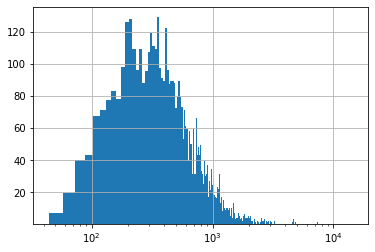

In [332]:
fig, ax = plt.subplots()
Full_df['Sequence Lengh'].hist(ax=ax, bins=1000, bottom=0.1)
ax.set_xscale('log')

In [333]:
indexNames = Full_df[ Full_df['Sequence Lengh'] > 1500 ].index
 
# Delete these row indexes from dataFrame
Full_df = Full_df.drop(indexNames , inplace=False).reset_index(drop=True)
Full_df.head()

,Lead Protein ID,Compartment Prediction,Prediction Confidence,Sequence,Sequence Lengh,ExpAA,First60,PredHel,Topology,Topology Seq,Prediction,SP(Sec/SPI),CS Position,Signal Peptide Seq
0,Q6RW13,Endosome,Very High,MELPAVNLKVILLGHWLLTTWGCIVFSGSYAWANFTILALGVWAVA...,159,69.11,32.19,3,"[24-46, 53-75, 85-107]",0000000000000000000000001111111111111111111111...,OTHER,0.011464,[],0000000000000000000000000000000000000000000000...
1,Q9P2R3,Endosome,Very High,MAEEEVAKLEKHLMLLRQEYVKLQKKLAETEKRCALLAAQANKESS...,1169,0.01,0.00,0,[],0000000000000000000000000000000000000000000000...,OTHER,0.000188,[],0000000000000000000000000000000000000000000000...
2,Q96NW4,Endosome,Very High,MALYDEDLLKNPFYLALQKCRPDLCSKVAQIHGIVLVPCKGSLSSS...,1050,0.09,0.00,0,[],0000000000000000000000000000000000000000000000...,OTHER,0.001217,[],0000000000000000000000000000000000000000000000...
3,O00203,Endosome,Very High,MSSNSFPYNEQSGGGEATELGQEATSTISPSGAFGLFSSDLKKNED...,1094,0.27,0.00,0,[],0000000000000000000000000000000000000000000000...,OTHER,0.000804,[],0000000000000000000000000000000000000000000000...
4,O14617,Endosome,Very High,MALKMVKGSIDRMFDKNLQDLVRGIRNHKEDEAKYISQCIDEIKQE...,1153,0.63,0.02,0,[],0000000000000000000000000000000000000000000000...,OTHER,0.000874,[],0000000000000000000000000000000000000000000000...


In [336]:
Full_df["Compartment Prediction"].value_counts() / len(Full_df) *100

Large Protein Complex     49.834437
Mitochondrion             13.514073
ER                        10.513245
Plasma membrane            9.788907
Endosome                   5.856788
Golgi                      3.683775
Lysosome                   1.800497
Actin binding proteins     1.676325
Ergic/cisGolgi             1.427980
ER_high_curvature          0.931291
Peroxisome                 0.517384
Nuclear pore complex       0.455298
Name: Compartment Prediction, dtype: float64

## Symplify dataset categories
Remove too small and merge what could be merged.

In [337]:
df_simple = Full_df.replace('ER_high_curvature', 'ER')
df_simple = df_simple[df_simple["Compartment Prediction"] != 'Nuclear pore complex'].reset_index(drop=True)
df_simple = df_simple[df_simple["Compartment Prediction"] != 'Peroxisome'].reset_index(drop=True)
df_simple = df_simple[df_simple["Compartment Prediction"] != 'Ergic/cisGolgi'].reset_index(drop=True)

# Remove actin because not a compartment, cannot be compared to other algorithm.
df_simple = df_simple[df_simple["Compartment Prediction"] != 'Actin binding proteins'].reset_index(drop=True)

In [338]:
df_simple["Compartment Prediction"].value_counts() / len(df_simple) *100

Large Protein Complex    51.952535
Mitochondrion            14.088457
ER                       11.930960
Plasma membrane          10.204962
Endosome                  6.105717
Golgi                     3.840345
Lysosome                  1.877023
Name: Compartment Prediction, dtype: float64

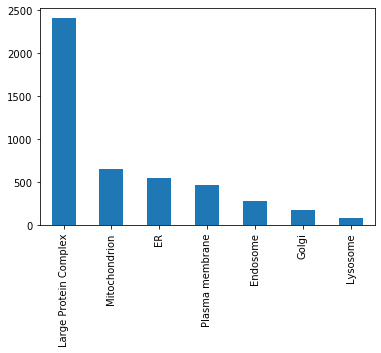

In [339]:
df_simple['Compartment Prediction'].value_counts().plot.bar()

In [340]:
df_simple.groupby(["Compartment Prediction", "Prediction"]).count()

Lead Protein ID  Prediction Confidence  \
Compartment Prediction Prediction                                            
ER                     OTHER                    370                    370   
                       SP(Sec/SPI)              183                    183   
Endosome               OTHER                    253                    253   
                       SP(Sec/SPI)               30                     30   
Golgi                  OTHER                    160                    160   
                       SP(Sec/SPI)               18                     18   
Large Protein Complex  OTHER                   2402                   2402   
                       SP(Sec/SPI)                6                      6   
Lysosome               OTHER                     35                     35   
                       SP(Sec/SPI)               52                     52   
Mitochondrion          OTHER                    645                    645   
                       SP(Sec/SPI)                8                      8   
Plasma membrane        OTHER                    339                    339   
                       SP(Sec/SPI)              134                    134   

                                    Sequence  Sequence Lengh  ExpAA  First60  \
Compartment Prediction Prediction                                              
ER                     OTHER             370             370    370      370   
                       SP(Sec/SPI)       183             183    183      183   
Endosome               OTHER             253             253    253      253   
                       SP(Sec/SPI)        30              30     30       30   
Golgi                  OTHER             160             160    160      160   
                       SP(Sec/SPI)        18              18     18       18   
Large Protein Complex  OTHER            2402            2402   2402     2402   
                       SP(Sec/SPI)         6               6      6        6   
Lysosome               OTHER              35              35     35       35   
                       SP(Sec/SPI)        52              52     52       52   
Mitochondrion          OTHER             645             645    645      645   
                       SP(Sec/SPI)         8               8      8        8   
Plasma membrane        OTHER             339             339    339      339   
                       SP(Sec/SPI)       134             134    134      134   

                                    PredHel  Topology  Topology Seq  \
Compartment Prediction Prediction                                     
ER                     OTHER            370       370           370   
                       SP(Sec/SPI)      183       183           183   
Endosome               OTHER            253       253           253   
                       SP(Sec/SPI)       30        30            30   
Golgi                  OTHER            160       160           160   
                       SP(Sec/SPI)       18        18            18   
Large Protein Complex  OTHER           2402      2402          2402   
                       SP(Sec/SPI)        6         6             6   
Lysosome               OTHER             35        35            35   
                       SP(Sec/SPI)       52        52            52   
Mitochondrion          OTHER            645       645           645   
                       SP(Sec/SPI)        8         8             8   
Plasma membrane        OTHER            339       339           339   
                       SP(Sec/SPI)      134       134           134   

                                    SP(Sec/SPI)  CS Position  \
Compartment Prediction Prediction                              
ER                     OTHER                370          370   
                       SP(Sec/SPI)          183          183   
Endosome               OTHER                253          253   
                       SP(Sec/SPI)           30  

## Spliting the Dataset

In [341]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
for train_index, test_index in split.split(df_simple, df_simple["Compartment Prediction"]):
    trainVal_set = df_simple.loc[train_index]
    test_set = df_simple.loc[test_index]

In [342]:
trainVal = trainVal_set.reset_index(drop=True)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.18, random_state=42)
for train_index, valid_index in split.split(trainVal, trainVal["Compartment Prediction"]):
    train_set = trainVal.loc[train_index]
    valid_set = trainVal.loc[valid_index]

In [343]:
train_set = train_set.reset_index(drop=True)
valid_set = valid_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)

In [344]:
print(train_set.shape)
print(valid_set.shape)
print(test_set.shape)

(3229, 14)
(710, 14)
(696, 14)


In [345]:
test_set["Compartment Prediction"].value_counts() / len(test_set) *100

Large Protein Complex    52.011494
Mitochondrion            14.080460
ER                       11.925287
Plasma membrane          10.201149
Endosome                  6.034483
Golgi                     3.879310
Lysosome                  1.867816
Name: Compartment Prediction, dtype: float64

In [346]:
train_set["Compartment Prediction"].value_counts() / len(train_set) *100

Large Protein Complex    51.935584
Mitochondrion            14.091050
ER                       11.923196
Plasma membrane          10.188913
Endosome                  6.131929
Golgi                     3.840198
Lysosome                  1.889130
Name: Compartment Prediction, dtype: float64

In [347]:
valid_set["Compartment Prediction"].value_counts() / len(valid_set) *100

Large Protein Complex    51.971831
Mitochondrion            14.084507
ER                       11.971831
Plasma membrane          10.281690
Endosome                  6.056338
Golgi                     3.802817
Lysosome                  1.830986
Name: Compartment Prediction, dtype: float64

In [348]:
train_set.to_csv(path_or_buf= "data/7C_train.csv", sep="\t", index=False)
valid_set.to_csv(path_or_buf= "data/7C_valid.csv", sep="\t", index=False)
test_set.to_csv(path_or_buf="data/7C_test.csv", sep="\t", index=False)